In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bidi.algorithm import get_display
from arabic_reshaper import reshape

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from dimension_reduction import DimensionReduction

from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical

import seaborn as sns
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection

from kneed import KneeLocator
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import accuracy_score
from sklearn.metrics.cluster import fowlkes_mallows_score
from sklearn.metrics import log_loss

import warnings
warnings.filterwarnings("ignore")

## Loading the dataset

In [2]:
df = pd.read_csv('data_total.csv')
df.head()

0         1         2         3         4         5         6         7  \
0  D_0  0.059704  0.087381  0.001719  0.358468  0.361588  0.227425  0.135941   
1  D_0  0.064066  0.085583  0.001278  0.382412  0.430429  0.274678  0.146284   
2  D_0  0.063933  0.079730  0.001191  0.315335  0.319210  0.170015  0.097739   
3  D_0  0.059029  0.085087  0.001522  0.403011  0.398137  0.249871  0.132644   
4  D_0  0.054941  0.083997  0.001787  0.358153  0.337478  0.242772  0.192074   

          8         9  ...         90         91         92         93  \
0  0.143317  0.115393  ...  21.546323  24.586190  55.200322  26.465070   
1  0.175509  0.101406  ...  22.111645  24.544797  56.097532  23.586952   
2  0.133261  0.089274  ...  22.057996  25.068478  55.802177  24.894988   
3  0.118595  0.096733  ...  22.348724  25.147534  55.096469  30.595766   
4  0.297731  0.132911  ...  21.124431  23.921915  53.962547  25.903111   

          94         95         96         97         98         99  
0  13.116643  16.736227  16.670350  11.982480  17.727448  19.906522  
1  13.098344  16.962624  15.963867  12.388751  16.783902  23.318567  
2  13.754883  18.469141  18.749436  11.648222  19.297149  20.035435  
3  13.352426  19.142054  20.146716  14.319667  23.763115  22.128027  
4  12.602666  16.513078  16.167857  11.463181  16.514866  11.953743  

[5 rows x 100 columns]

In [3]:
X = df.drop(["0"], axis=1)
y = df["0"]

# Preprocess
#### Label Encoding

In [4]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)

#### Train Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=31)

Text(0.5, 1.0, 'Dastgah Frequency of Train')

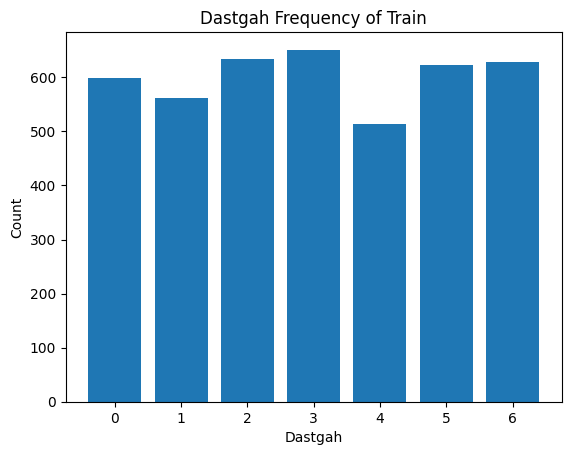

In [6]:
plt.bar(list(Counter(y_train).keys()), list(Counter(y_train).values()))
plt.xlabel('Dastgah')
plt.ylabel('Count')
plt.title('Dastgah Frequency of Train')

Text(0.5, 1.0, 'Dastgah Frequency of Test')

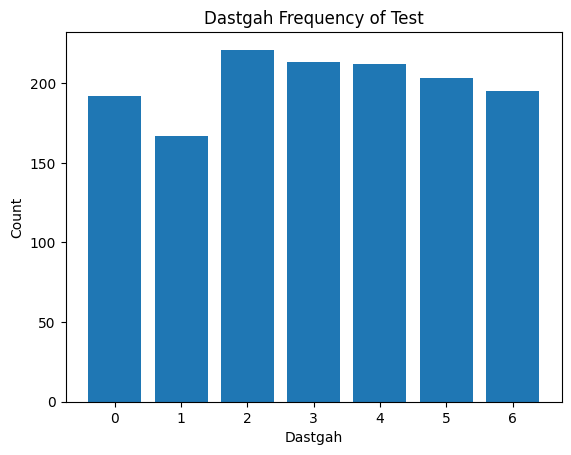

In [7]:
plt.bar(list(Counter(y_test).keys()), list(Counter(y_test).values()))
plt.xlabel('Dastgah')
plt.ylabel('Count')
plt.title('Dastgah Frequency of Test')

#### Normalization

In [8]:
scaler = StandardScaler()
X_test = scaler.fit_transform(np.array(X_test, dtype = float))
X_train = scaler.transform(np.array(X_train, dtype = float))

# Classification

In [9]:
dastgah = {
    0: "شور",
    1: "سه‌گاه",
    2: "ماهور",
    3: "همایون",
    4: "راست پنج‌گاه",
    5: "نوا",
    6: "چهارگاه"
}

In [10]:
def evaluate(model):
    print("--------------------------------Train-------------------------------\n")
    print(classification_report(y_train, model.predict(X_train)))
    print("Error:", log_loss(y_train, model.predict_proba(X_train)))
    print("\n")
    print("--------------------------------Test--------------------------------\n")
    print(classification_report(y_test, model.predict(X_test)))
    print("Error:", log_loss(y_test, model.predict_proba(X_test)))

In [11]:
def plot_roc_curve(model, X, y, n_classes, title):
    y = label_binarize(y, classes = np.arange(n_classes))
    y_pred = label_binarize(model.predict(X), classes = np.arange(n_classes))

    for i in range(n_classes):
        fpr, tpr, thresholds = roc_curve(y[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        label = 'ROC of class {0} (area={1:0.2f})'.format(i, roc_auc)
        plt.plot(fpr, tpr, label = label)
        plt.plot([0, 1], [0, 1], linestyle = '--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve of ' + title)
        plt.legend(loc = 'lower right')

    plt.show()

In [12]:
def display_model_history(history):
  plt.figure(figsize=(10, 5)) 
  plt.plot(history.history['accuracy'], label = 'Train')
  plt.plot(history.history['val_accuracy'], label = 'Validation')
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  plt.figure(figsize=(10, 5)) 
  plt.plot(history.history['loss'], label = 'Train')
  plt.plot(history.history['val_loss'], label = 'Validation')
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [13]:
def categories_bar_plot(model, X, y, n_classes, title):
    y_pred = model.predict(X)
    results = pd.DataFrame()
    results['Dastgah'] = y
    results['Dastgah']=results['Dastgah'].apply(lambda x: get_display(reshape(dastgah[x])))
    results = pd.get_dummies(results['Dastgah'])
    results['Predicted'] = y_pred
    results['Predicted']=results['Predicted'].apply(lambda x: get_display(reshape(dastgah[x])))
    results = results.groupby(['Predicted']).sum() 
    fig, ax  = plt.subplots(1,1)
    results.plot.bar(ax = ax,rot=0,figsize=(10, 4))
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel("Predicted Category")
    ax.set_ylabel("Count")
    ax.set_title("Categories bar plot for "+title)
    plt.show()

In [14]:
def heatmap_plot(model, X, y, title):
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    sortedlabels = [get_display(reshape(label)) for label in dastgah.values()]
    cm = pd.DataFrame(cm, index=[sortedlabels], columns=sortedlabels)
    plt.figure(figsize = (10,5))
    sns.heatmap(cm, linewidths=0.5, annot=True, cmap="Blues", fmt='g')
    plt.title("Confusiuon Matrix Heatmap for "+title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

#### Support Vector Machine(SVM)

In [15]:
c = [1e-1, 1e0, 1e1]
gammas = [1e-1, 1e0, 1e1]
model = SVC(kernel = 'rbf', decision_function_shape = 'ovr')
params = dict(C = c, gamma = gammas)
svc = GridSearchCV(model, params, cv = 10)
svc.fit(X_train, y_train)
print('Best parameters for SVM:', svc.best_params_)

Best parameters for SVM: {'C': 10.0, 'gamma': 0.1}


#### Applying the best parameters

In [16]:
best_svc = SVC(
    kernel = 'rbf', 
    decision_function_shape = 'ovr', 
    C=svc.best_params_['C'], 
    gamma=svc.best_params_['gamma'],
    probability=True
)
best_svc.fit(X_train, y_train)
evaluate(best_svc)

--------------------------------Train-------------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       598
           1       1.00      1.00      1.00       562
           2       1.00      1.00      1.00       633
           3       1.00      1.00      1.00       651
           4       1.00      0.98      0.99       513
           5       0.99      1.00      0.99       623
           6       1.00      1.00      1.00       629

    accuracy                           1.00      4209
   macro avg       1.00      1.00      1.00      4209
weighted avg       1.00      1.00      1.00      4209

Error: 0.008576157620670107


--------------------------------Test--------------------------------

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       192
           1       0.95      0.90      0.93       167
           2       0.83      0.95      0.88       221
           3    

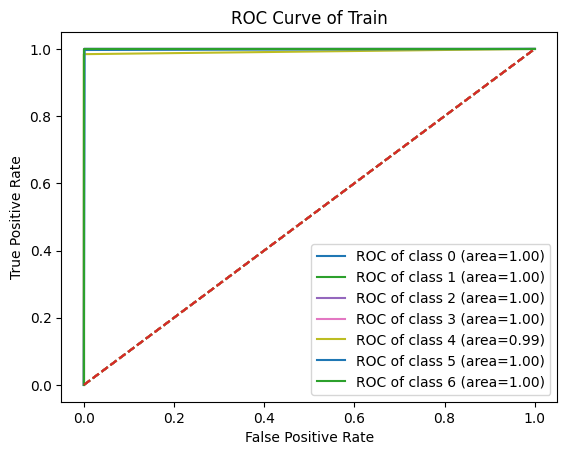

In [17]:
plot_roc_curve(svc, X_train, y_train, n_classes=7, title="Train")

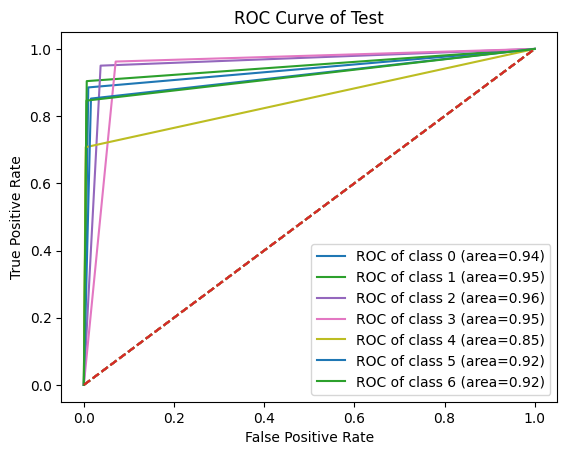

In [18]:
plot_roc_curve(svc, X_test, y_test, n_classes = 7, title="Test")

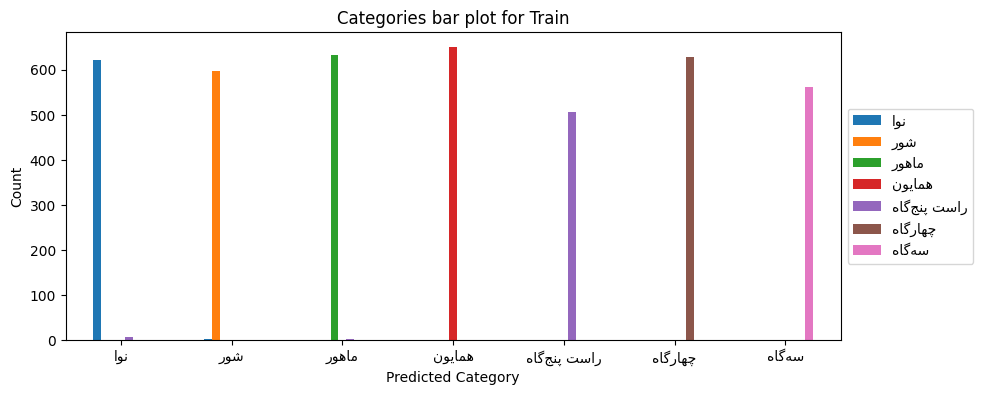

In [19]:
categories_bar_plot(best_svc, X_train, y_train, n_classes=7, title="Train")

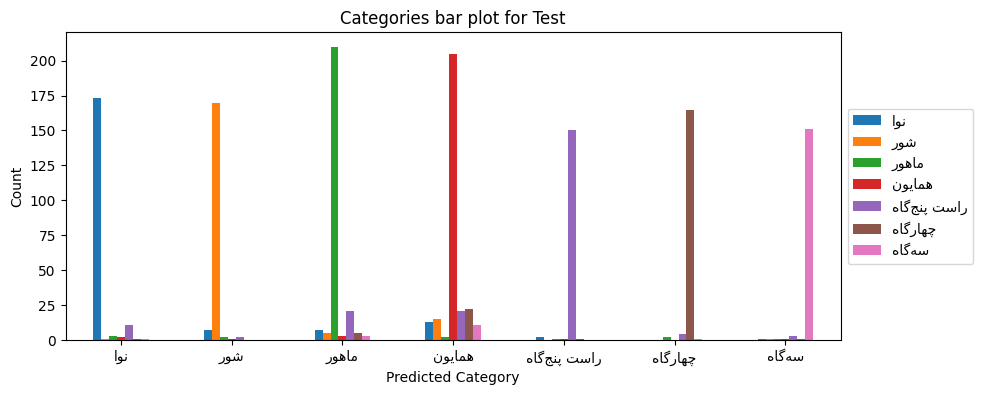

In [20]:
categories_bar_plot(best_svc, X_test, y_test, n_classes=7, title="Test")

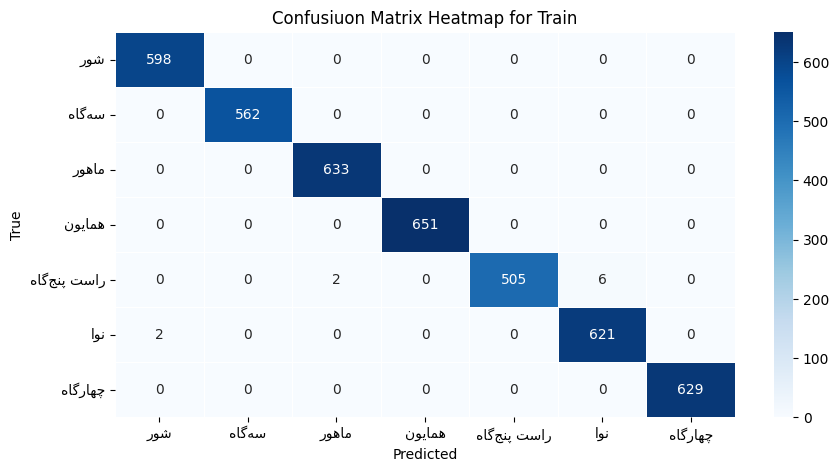

In [21]:
heatmap_plot(best_svc, X_train, y_train, title="Train")

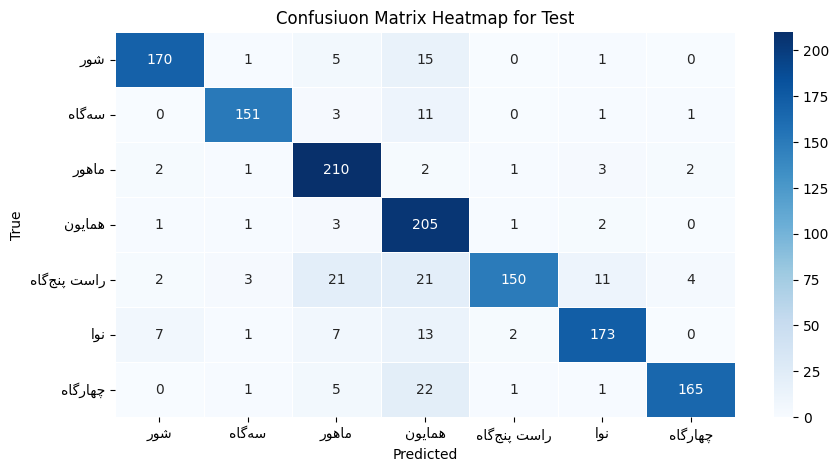

In [22]:
heatmap_plot(best_svc, X_test, y_test, title="Test")

#### K-Nearest Neighbors(KNN)

In [23]:
k_range = np.arange(2, 20)
params = dict(n_neighbors=k_range)
model = KNeighborsClassifier(weights='distance', metric='manhattan')
KNN = GridSearchCV(model, params, cv = 10)
KNN.fit(X_train, y_train)
print('Best K for KNN:', KNN.best_params_)

Best K for KNN: {'n_neighbors': 2}


#### Applying the best parameters

In [24]:
best_KNN = KNeighborsClassifier(
    n_neighbors=KNN.best_params_["n_neighbors"],
    weights='distance', 
    metric='manhattan'
)
best_KNN.fit(X_train, y_train)
evaluate(best_KNN)

--------------------------------Train-------------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       598
           1       1.00      1.00      1.00       562
           2       1.00      1.00      1.00       633
           3       1.00      1.00      1.00       651
           4       0.99      1.00      0.99       513
           5       1.00      0.99      0.99       623
           6       1.00      1.00      1.00       629

    accuracy                           1.00      4209
   macro avg       1.00      1.00      1.00      4209
weighted avg       1.00      1.00      1.00      4209

Error: 0.0032936430532678803


--------------------------------Test--------------------------------

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       192
           1       0.93      0.98      0.95       167
           2       0.92      0.94      0.93       221
           3   

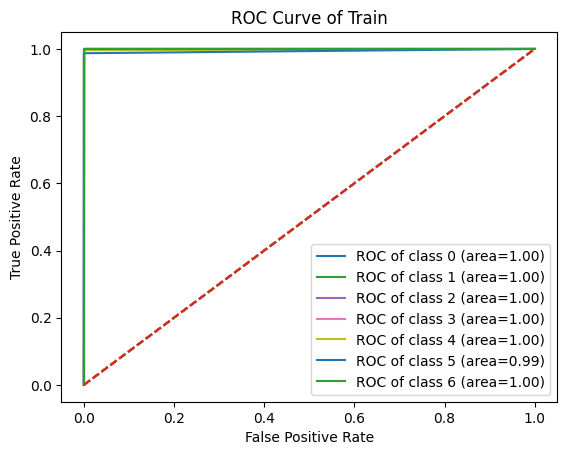

In [25]:
plot_roc_curve(KNN, X_train, y_train, n_classes = 7, title="Train")

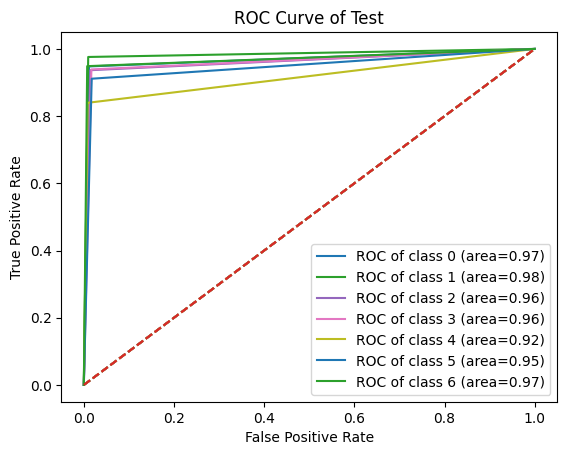

In [26]:
plot_roc_curve(KNN, X_test, y_test, n_classes = 7, title="Test")

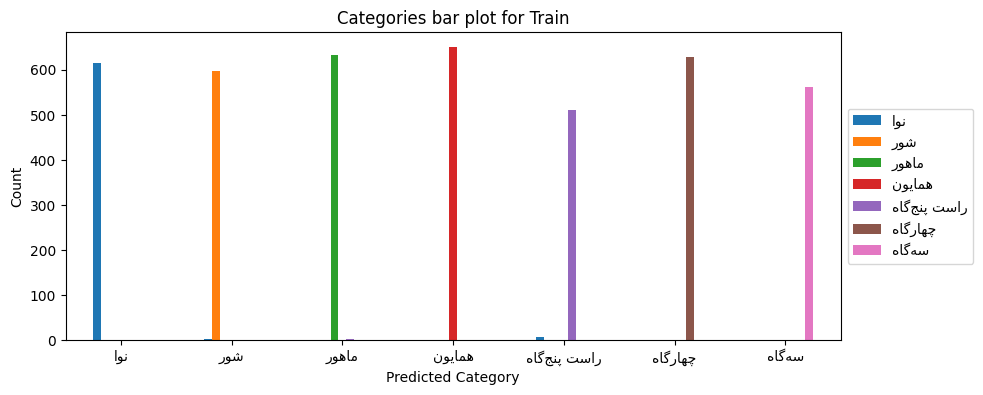

In [27]:
categories_bar_plot(best_KNN, X_train, y_train, n_classes=7, title="Train")

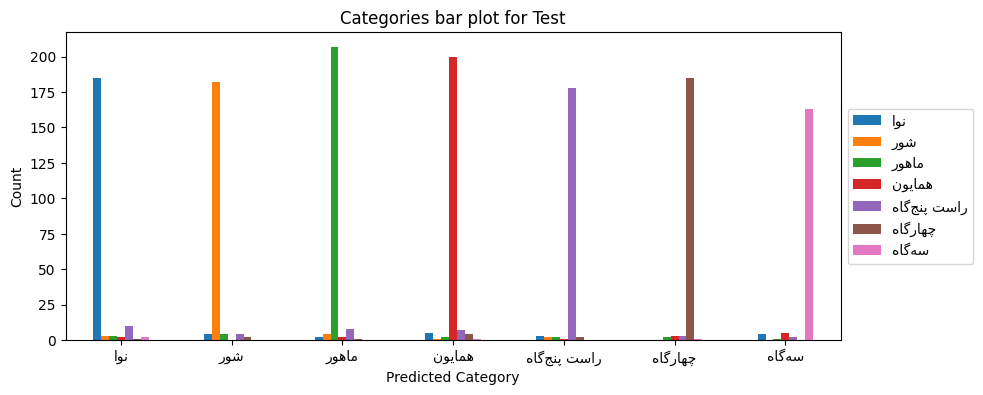

In [28]:
categories_bar_plot(best_KNN, X_test, y_test, n_classes=7, title="Test")

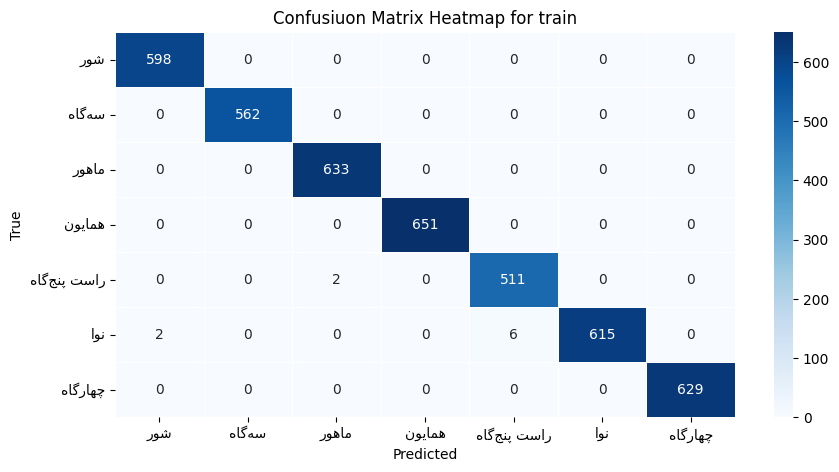

In [29]:
heatmap_plot(best_KNN, X_train, y_train, title="train")

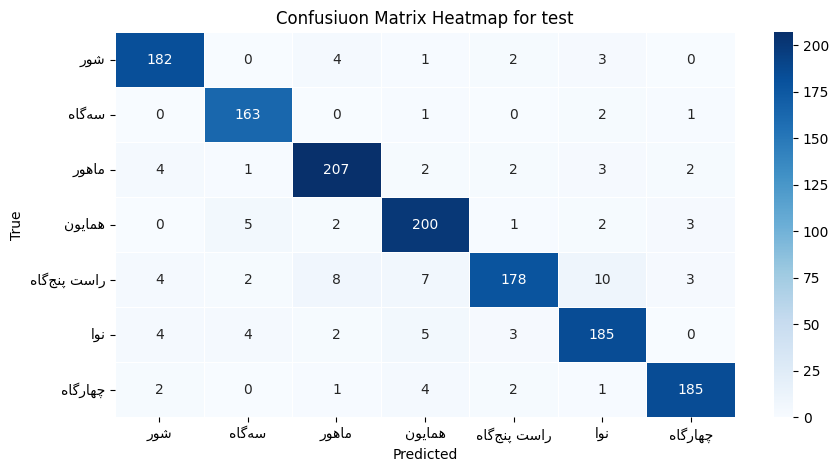

In [30]:
heatmap_plot(best_KNN, X_test, y_test, title="test")

#### XGBoost

In [31]:
xgb = XGBClassifier(n_estimators=300)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [32]:
evaluate(xgb)

--------------------------------Train-------------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       598
           1       1.00      1.00      1.00       562
           2       1.00      1.00      1.00       633
           3       1.00      1.00      1.00       651
           4       0.99      0.99      0.99       513
           5       1.00      0.99      0.99       623
           6       1.00      1.00      1.00       629

    accuracy                           1.00      4209
   macro avg       1.00      1.00      1.00      4209
weighted avg       1.00      1.00      1.00      4209

Error: 0.005794619381878384


--------------------------------Test--------------------------------

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       192
           1       0.88      0.89      0.88       167
           2       0.84      0.85      0.84       221
           3    

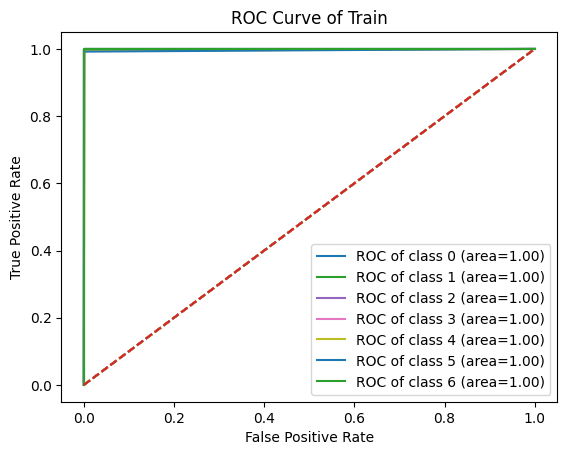

In [33]:
plot_roc_curve(xgb, X_train, y_train, n_classes = 7, title="Train")

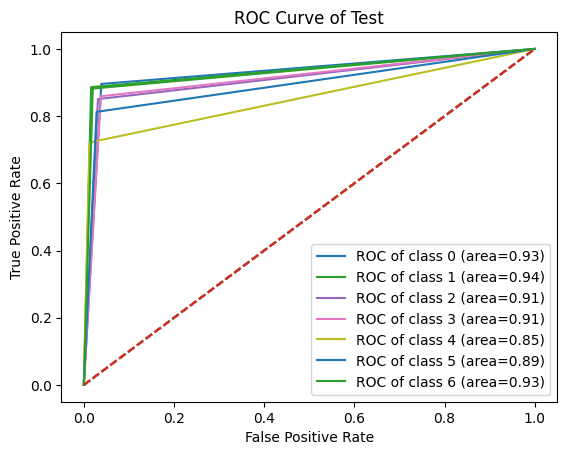

In [34]:
plot_roc_curve(xgb, X_test, y_test, n_classes = 7, title="Test")

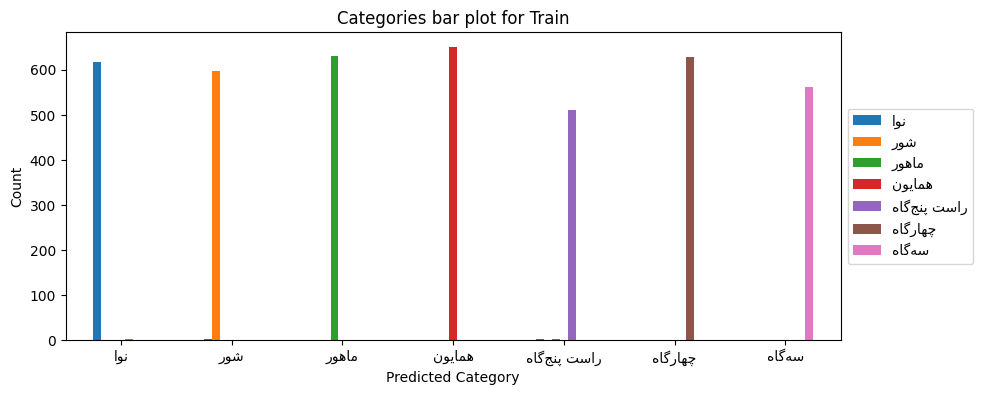

In [35]:
categories_bar_plot(xgb, X_train, y_train, n_classes=7, title="Train")

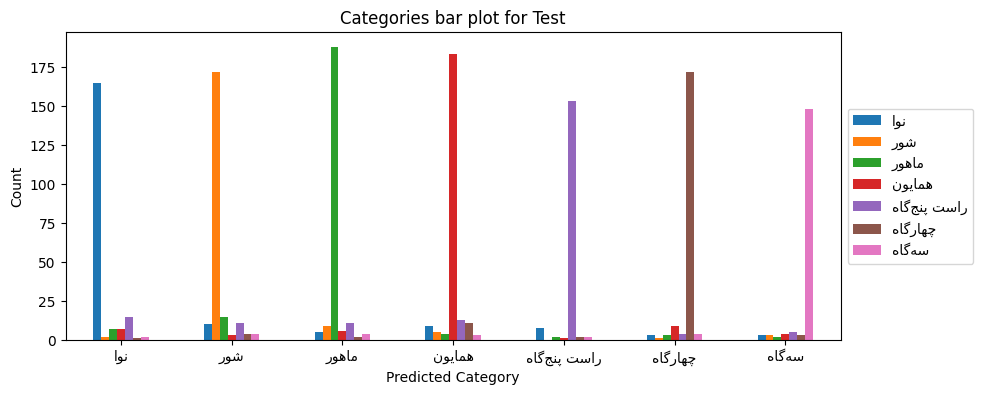

In [36]:
categories_bar_plot(xgb, X_test, y_test, n_classes=7, title="Test")

#### MLP

#### Applying the best parameters

In [37]:
best_MLP = MLPClassifier(hidden_layer_sizes = (128, 64, 32, 8), batch_size = 16, solver = 'sgd', random_state=4,
                    verbose=False, momentum=0.85, max_iter=400, learning_rate_init = 0.006)
best_MLP.fit(X_train, y_train)

MLPClassifier(batch_size=16, hidden_layer_sizes=(128, 64, 32, 8),
              learning_rate_init=0.006, max_iter=400, momentum=0.85,
              random_state=4, solver='sgd')

In [38]:
evaluate(best_MLP)

--------------------------------Train-------------------------------

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       598
           1       1.00      1.00      1.00       562
           2       1.00      1.00      1.00       633
           3       1.00      1.00      1.00       651
           4       1.00      0.98      0.99       513
           5       0.99      1.00      0.99       623
           6       1.00      1.00      1.00       629

    accuracy                           1.00      4209
   macro avg       1.00      1.00      1.00      4209
weighted avg       1.00      1.00      1.00      4209

Error: 0.004715097315903805


--------------------------------Test--------------------------------

              precision    recall  f1-score   support

           0       0.78      0.82      0.80       192
           1       0.83      0.84      0.84       167
           2       0.84      0.85      0.84       221
           3    

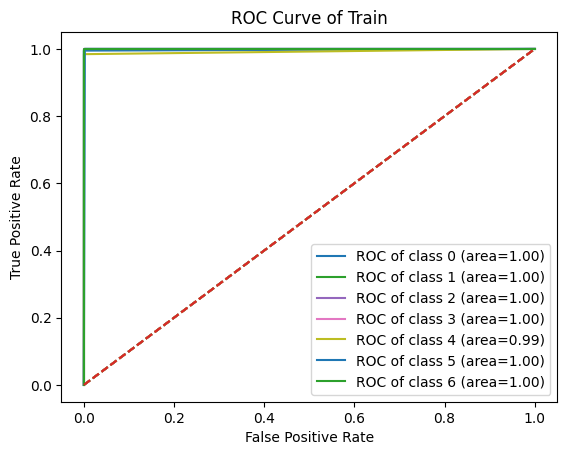

In [39]:
plot_roc_curve(best_MLP, X_train, y_train, n_classes = 7, title="Train")

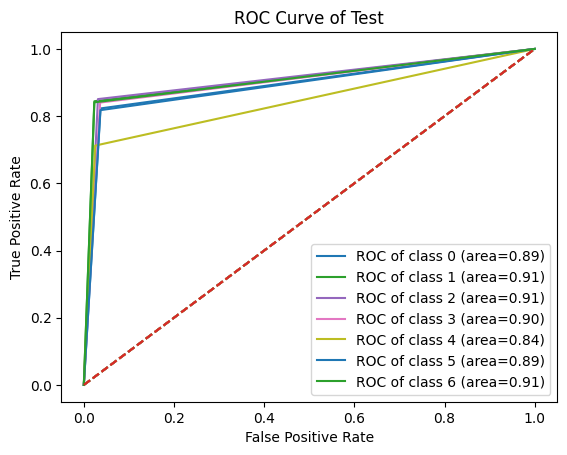

In [40]:
plot_roc_curve(best_MLP, X_test, y_test, n_classes = 7, title="Test")

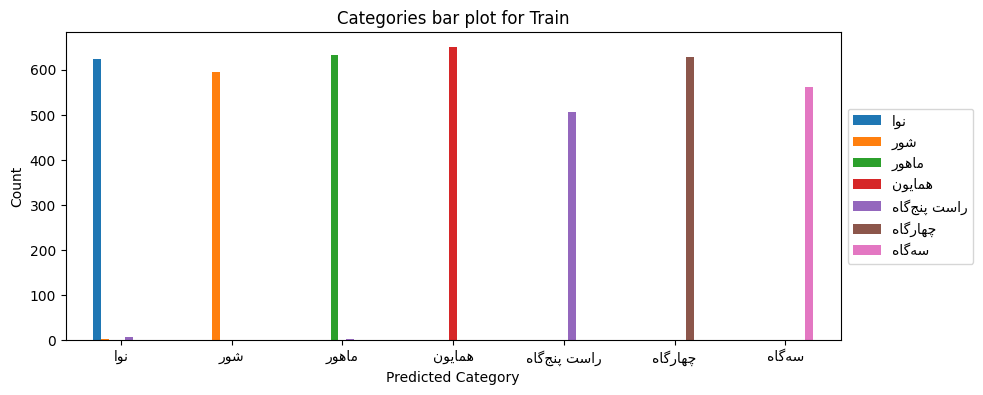

In [41]:
categories_bar_plot(best_MLP, X_train, y_train, n_classes=7, title="Train")

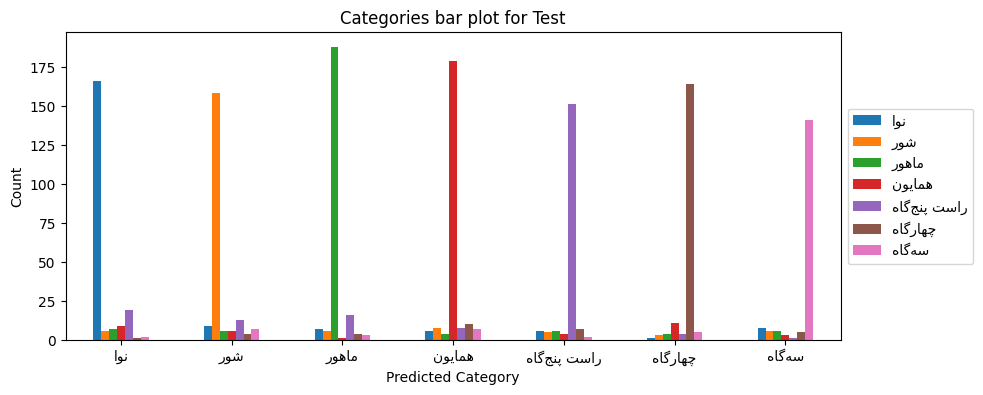

In [42]:
categories_bar_plot(best_MLP, X_test, y_test, n_classes=7, title="Test")

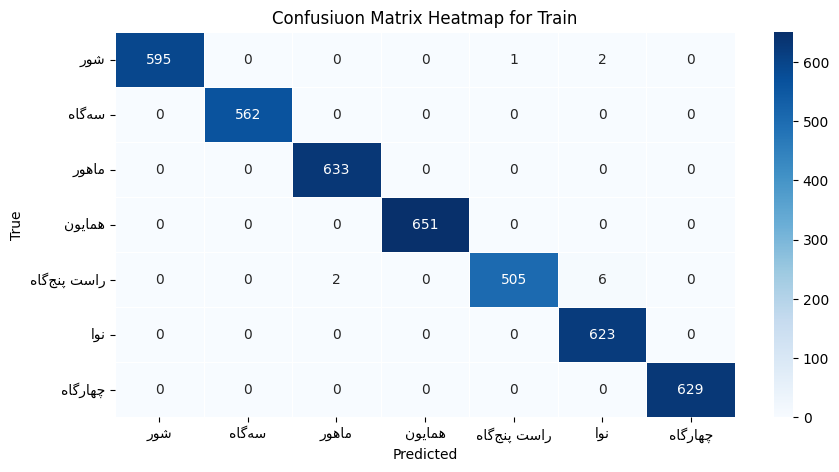

In [43]:
heatmap_plot(best_MLP, X_train, y_train, title="Train")

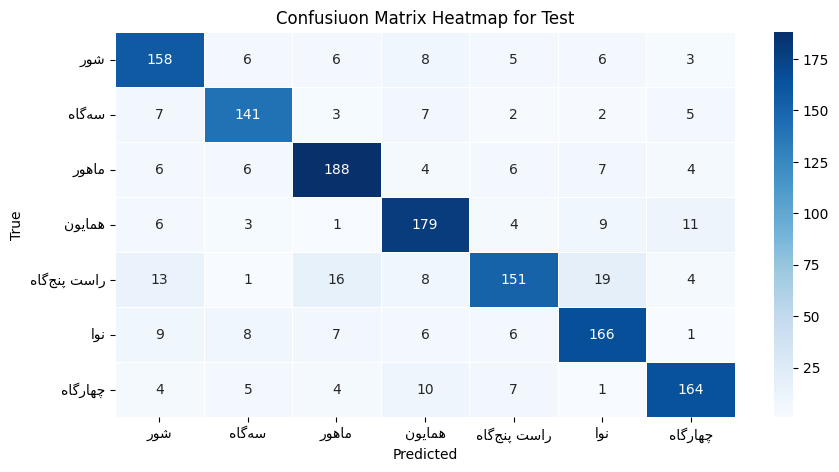

In [44]:
heatmap_plot(best_MLP, X_test, y_test, title="Test")

#### Logistic Regression

In [45]:
model = LogisticRegression()
params = [{'penalty':['l1','l2'], 'C':np.logspace(-4, 4, 12)}]
lr = GridSearchCV(model, params, cv = 10)
lr.fit(X_train, y_train)
print("Best parameters for Logistic Regression:(best parameters) ",lr.best_params_)

Best parameters for Logistic Regression:(best parameters)  {'C': 2.310129700083158, 'penalty': 'l2'}


#### Applying the best parameters

In [46]:
best_lr = LogisticRegression( C=lr.best_params_['C'], penalty=lr.best_params_['penalty'])
best_lr.fit(X_train, y_train)
evaluate(best_lr)

--------------------------------Train-------------------------------

              precision    recall  f1-score   support

           0       0.42      0.38      0.40       598
           1       0.50      0.52      0.51       562
           2       0.45      0.46      0.45       633
           3       0.44      0.48      0.46       651
           4       0.42      0.36      0.39       513
           5       0.49      0.47      0.48       623
           6       0.50      0.55      0.53       629

    accuracy                           0.46      4209
   macro avg       0.46      0.46      0.46      4209
weighted avg       0.46      0.46      0.46      4209

Error: 1.4846383125378444


--------------------------------Test--------------------------------

              precision    recall  f1-score   support

           0       0.38      0.34      0.36       192
           1       0.46      0.55      0.50       167
           2       0.41      0.40      0.40       221
           3      

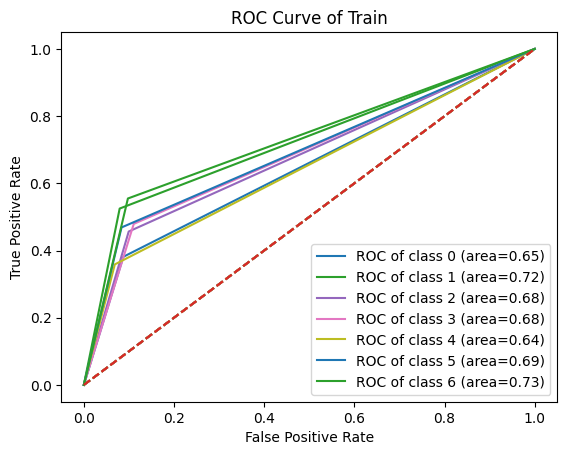

In [47]:
plot_roc_curve(best_lr, X_train, y_train, n_classes = 7, title="Train")

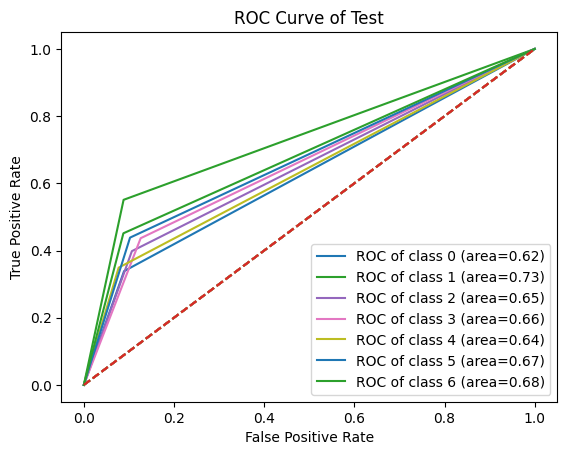

In [48]:
plot_roc_curve(best_lr, X_test, y_test, n_classes = 7, title="Test")

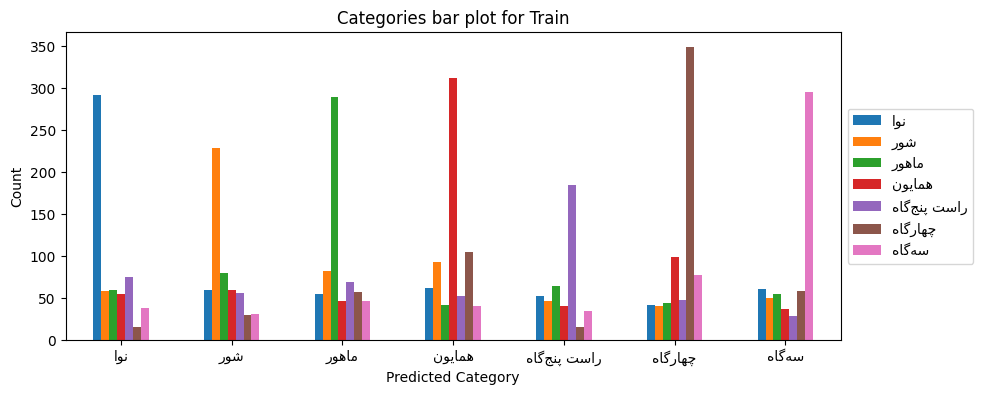

In [49]:
categories_bar_plot(best_lr, X_train, y_train, n_classes=7, title="Train")

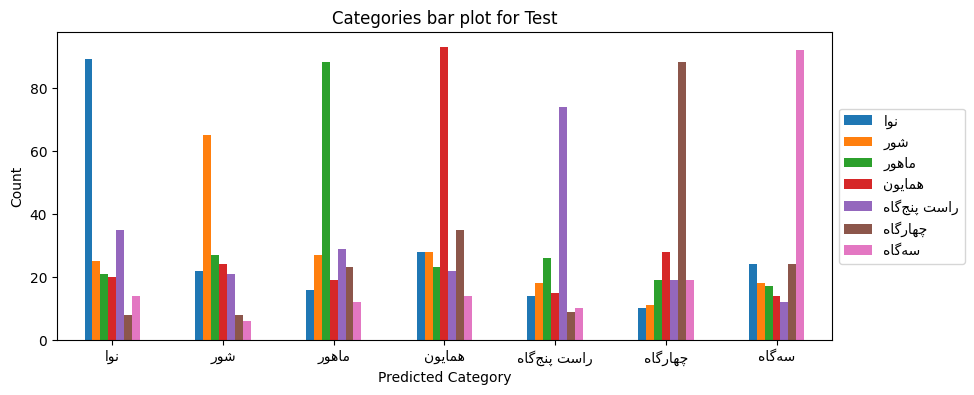

In [50]:
categories_bar_plot(best_lr, X_test, y_test, n_classes=7, title="Test")

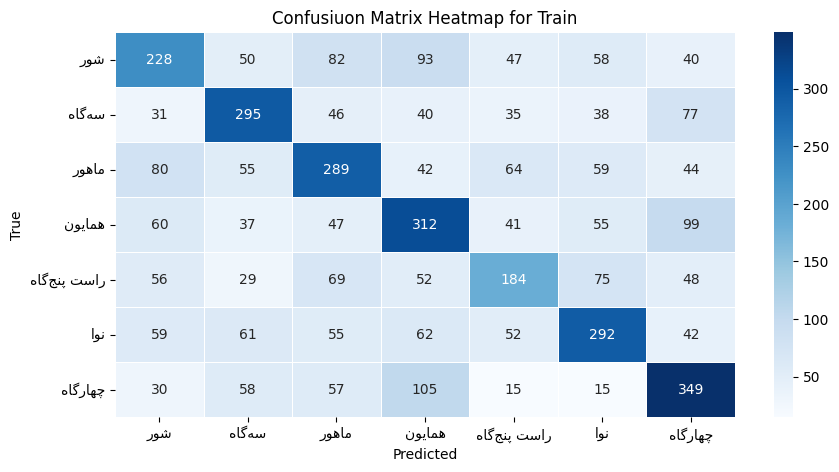

In [51]:
heatmap_plot(best_lr, X_train, y_train, title="Train")

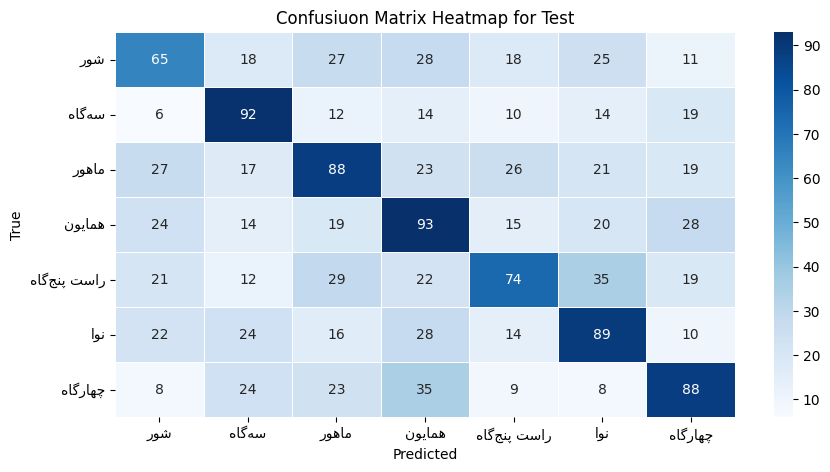

In [52]:
heatmap_plot(best_lr, X_test, y_test, title="Test")

#### LSTM

In [53]:
X_train_new, X_valid, y_train_new, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=31)
y_train_one_hot = to_categorical(y_train_new)
y_valid_one_hot = to_categorical(y_valid)

model = Sequential()
model.add(LSTM(units=128, dropout=0.1, recurrent_dropout=0.35, return_sequences=True, input_shape=(X_train_new.shape[1], 1)))
model.add(LSTM(units=64,  dropout=0.1, recurrent_dropout=0.35, return_sequences=False))
model.add(Dense(units=y_train_one_hot.shape[1], activation="softmax"))

print("Compiling ...")
model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics = ['accuracy'])
model.summary()

print("Training ...")
history = model.fit(X_train_new, y_train_one_hot, batch_size=64, epochs=80, validation_data = (X_valid, y_valid_one_hot))

2023-02-13 22:37:29.931852: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Compiling ...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 99, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 7)                 455       
                                                                 
Total params: 116,423
Trainable params: 116,423
Non-trainable params: 0
_________________________________________________________________
Training ...
Epoch 1/80
60/60 [==============================] - 17s 191ms/step - loss: 1.9392 - accuracy: 0.1700 - val_loss: 1.9480 - val_accuracy: 0.1283
Epoch 2/80
60/60 [==============================] - 11s 181ms/step - loss: 1.9284 - accuracy: 0.1872 - val_loss: 1.9397 - val_accuracy: 0.1900
E

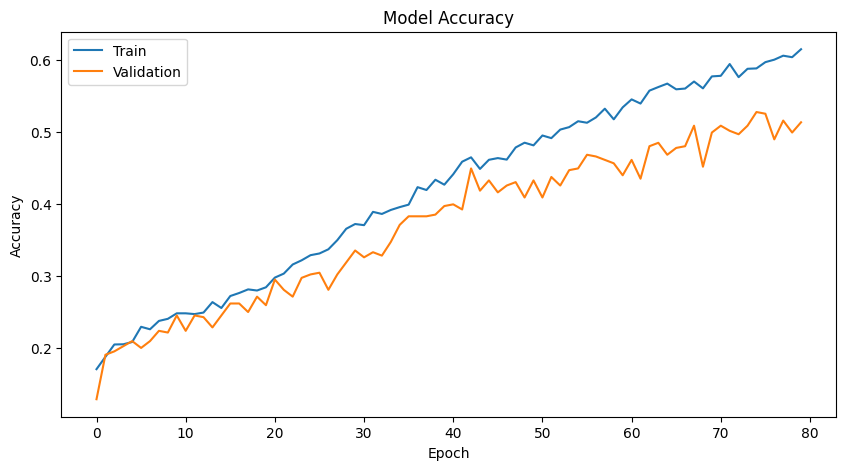

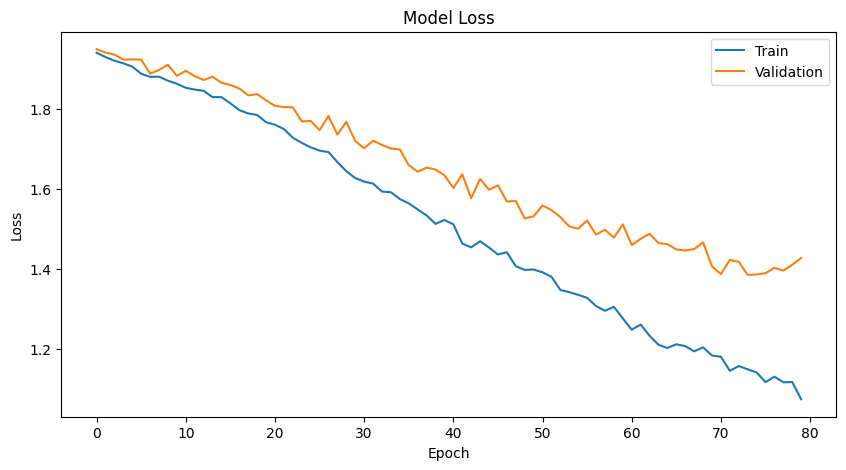

In [54]:
display_model_history(history)

In [56]:
y_pred = np.argmax(model.predict(X_train), axis = 1)
print("--------------------------------Train-------------------------------\n")
print(classification_report(y_train, y_pred))

132/132 [==============================] - 3s 26ms/step
--------------------------------Train-------------------------------

              precision    recall  f1-score   support

           0       0.78      0.73      0.75       598
           1       0.78      0.79      0.79       562
           2       0.76      0.74      0.75       633
           3       0.76      0.70      0.73       651
           4       0.81      0.62      0.70       513
           5       0.68      0.77      0.72       623
           6       0.67      0.81      0.73       629

    accuracy                           0.74      4209
   macro avg       0.75      0.74      0.74      4209
weighted avg       0.75      0.74      0.74      4209



In [57]:
y_pred = np.argmax(model.predict(X_test), axis = 1)
print("--------------------------------Test--------------------------------\n")
print(classification_report(y_test, y_pred))

44/44 [==============================] - 1s 23ms/step
--------------------------------Test--------------------------------

              precision    recall  f1-score   support

           0       0.53      0.50      0.51       192
           1       0.60      0.69      0.64       167
           2       0.67      0.63      0.65       221
           3       0.57      0.55      0.56       213
           4       0.69      0.43      0.53       212
           5       0.46      0.57      0.51       203
           6       0.52      0.61      0.56       195

    accuracy                           0.57      1403
   macro avg       0.58      0.57      0.57      1403
weighted avg       0.58      0.57      0.56      1403



# Feature Selection
#### Linear Discriminant Analysis(LDA)

In [58]:
dr = DimensionReduction(X_train, y_train, X_test, y_test)
X_train_lda, X_test_lda = dr.LDA(n_components=2)

# Clustring 

Determining the ideal number of clusters:

Optimal number of clusters:  6


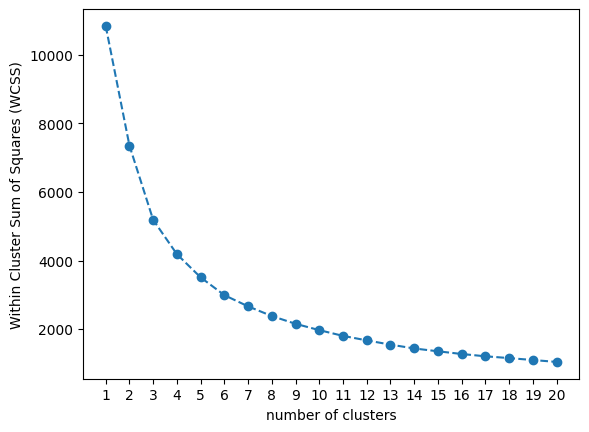

In [59]:
def calculate_erros(data, kmax):
    wse = []
    for k in range(1, kmax+1):
        err = 0
        kmeans = KMeans(n_clusters=k, init='k-means++', algorithm='elkan', max_iter=100).fit(data)
        pred_clusters = kmeans.predict(data)
        for i in range(len(data)):
            center = kmeans.cluster_centers_[pred_clusters[i]]
            err += (data[i, 0] - center[0]) ** 2 + (data[i, 1] -center[1]) ** 2
        wse.append(err)
    return wse

list_of_wss = calculate_erros(X_train_lda, 20)
optimal_k = KneeLocator([i for i in range(1, 21)], list_of_wss, curve='convex', direction='decreasing').knee
print("Optimal number of clusters: ", optimal_k)
plt.plot(range(1, 21), list_of_wss, marker='o',  linestyle='--')
plt.xlabel('number of clusters')
plt.ylabel('Within Cluster Sum of Squares (WCSS)')
plt.xticks(range(1, 21))
plt.show()

In [60]:
def plot_dendrogram(train_data,test_data,num_of_features):
    fig, axes = plt.subplots(ncols=2, nrows=1,figsize=(25, 10))
    axes[0].set_title('Dendogram for Train Data with '+ str(num_of_features) +' features')
    clusters = linkage(train_data, method='ward')
    dendrogram(clusters,truncate_mode='lastp',show_contracted=True,ax=axes[0],no_labels=True)
    axes[1].set_title('Dendogram for Test Data with '+ str(num_of_features) +' features')
    clusters = linkage(test_data, method='ward')
    dendrogram(clusters,truncate_mode='lastp',show_contracted=True,ax=axes[1],no_labels=True)
    plt.show()

## Clustring Using Data with 2 Features

In [61]:
def evaluate_clustering(model, number_of_clusters, model_name, d=2):
    if d == 2:
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].scatter(X_train_lda[:, 0], X_train_lda[:, 1], c=model.fit_predict(X_train))
        ax[0].set_title(f"{model_name} Train\nNumber of Clusters: {number_of_clusters}\nFowlkes Mallow Score: {fowlkes_mallows_score(y_train, model.fit_predict(X_train))}")

        ax[1].scatter(X_test_lda[:, 0], X_test_lda[:, 1], c=model.fit_predict(X_test))
        ax[1].set_title(f"{model_name} Test\nNumber of Clusters: {number_of_clusters}\nFowlkes Mallow Score: {fowlkes_mallows_score(y_test, model.fit_predict(X_test))}")
    
    
    if d == 3:
        fig, ax = plt.subplots(1, 2, figsize=(12, 9), subplot_kw=dict(projection='3d'))
        
        ax[0].scatter(X_train_lda[:, 0], X_train_lda[:, 1], X_train_lda[:, 2], c=model.fit_predict(X_train))
        ax[0].set_title(f"{model_name} Train\nNumber of Clusters: {number_of_clusters}\nFowlkes Mallows Score: {fowlkes_mallows_score(y_train, model.fit_predict(X_train))}")

        ax[1].scatter(X_test_lda[:, 0], X_test_lda[:, 1], X_test_lda[:, 2], c=model.fit_predict(X_test))
        ax[1].set_title(f"{model_name} Test\nNumber of Clusters: {number_of_clusters}\nFowlkes Mallow Score: {fowlkes_mallows_score(y_test, model.fit_predict(X_test))}")
    
    fig.tight_layout()
    plt.show()

## K-Means 

In [62]:
clusters = [2, 7, 20]

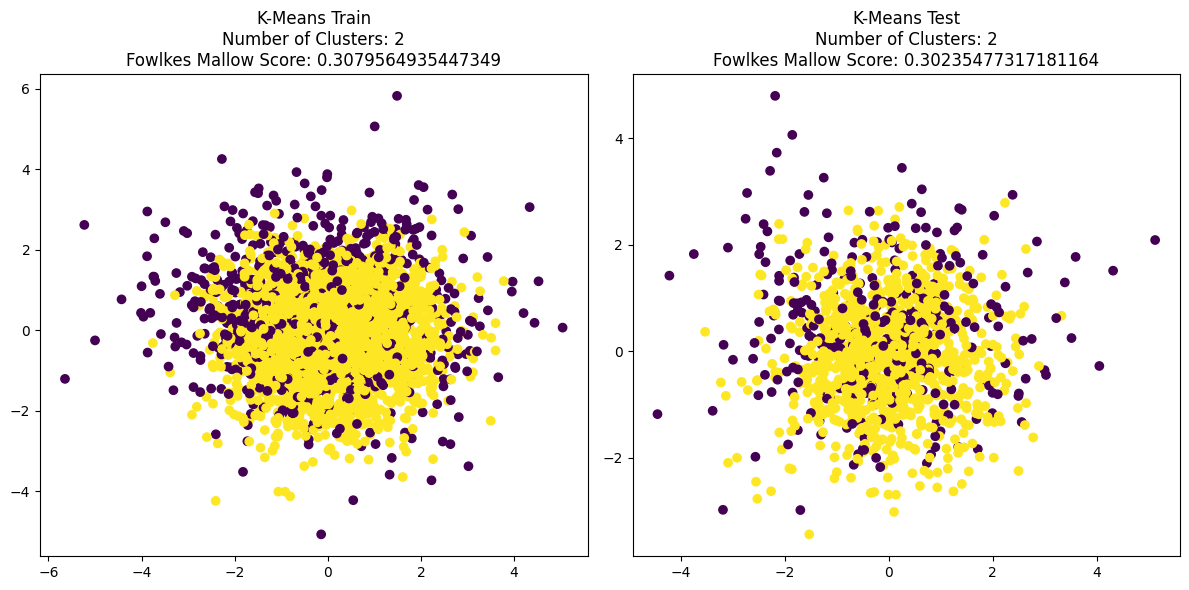

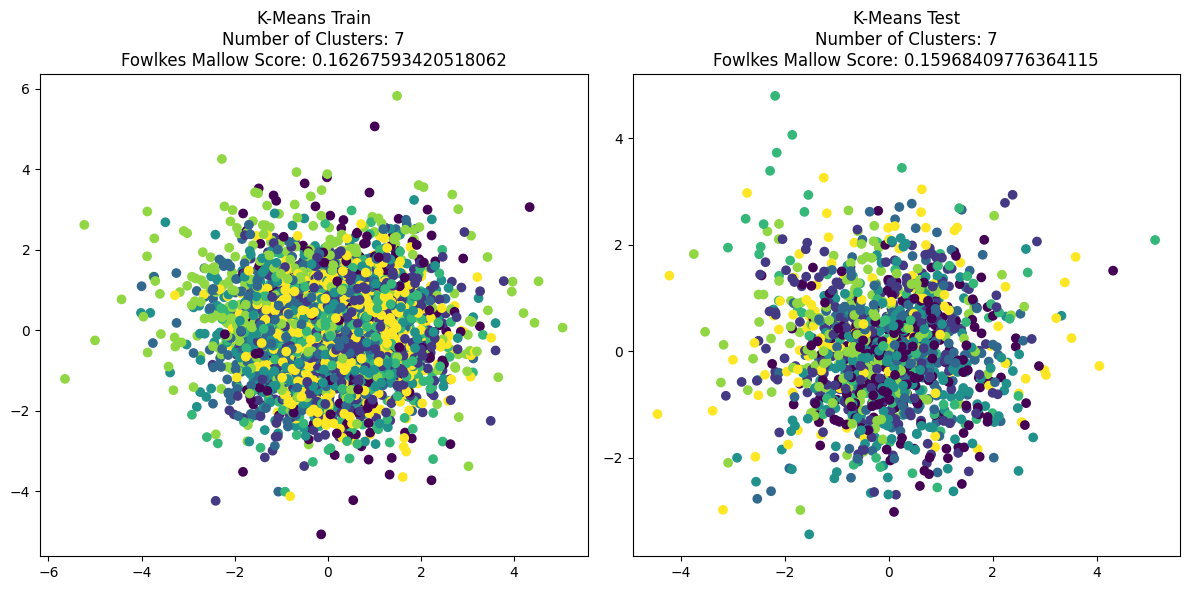

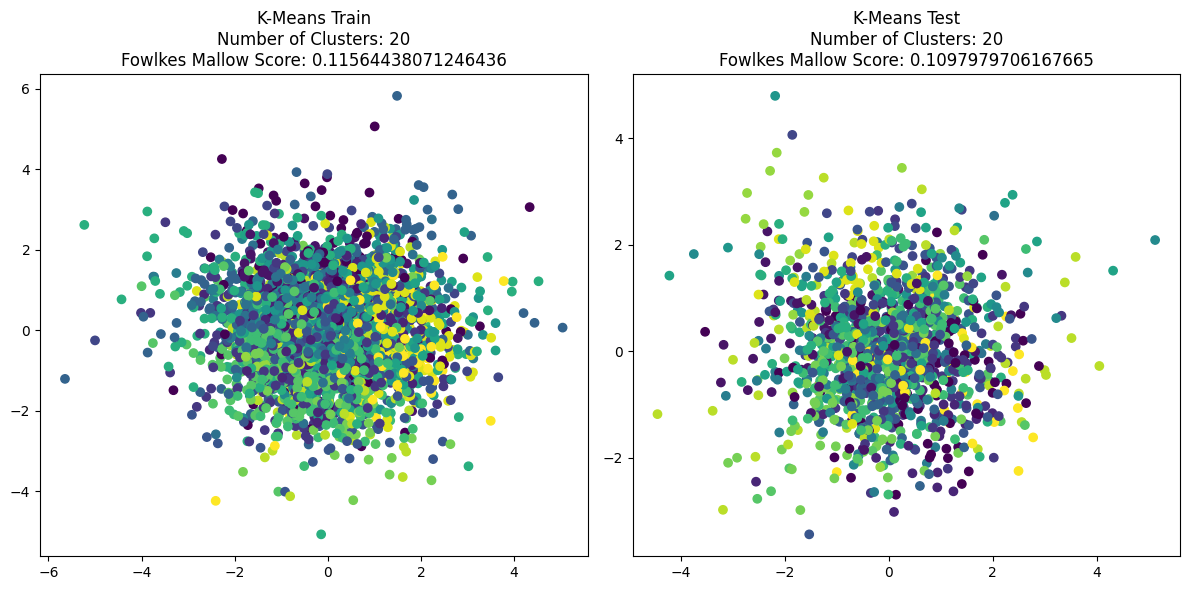

In [63]:
for n_clusters in clusters:
    kMeans = KMeans(n_clusters=n_clusters, init='k-means++', algorithm='elkan', max_iter=100)
    kMeans.fit(X_train_lda)
    # print('Number of clusters = ', n_clusters)
    evaluate_clustering(kMeans, number_of_clusters=n_clusters, model_name="K-Means")
    plt.show()

## Agglomerative

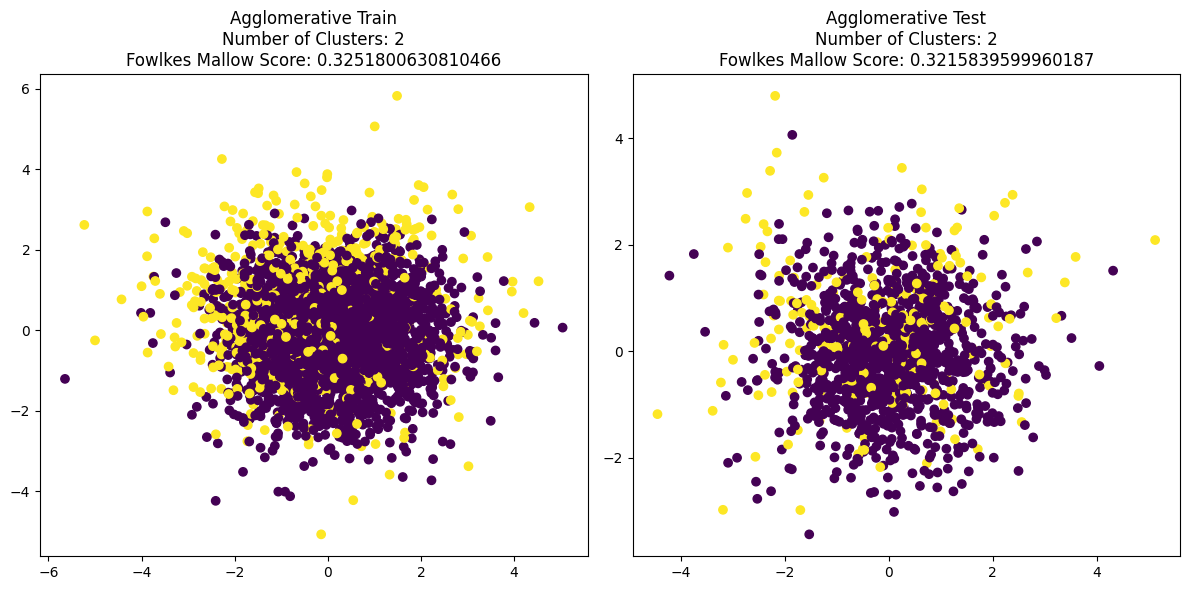

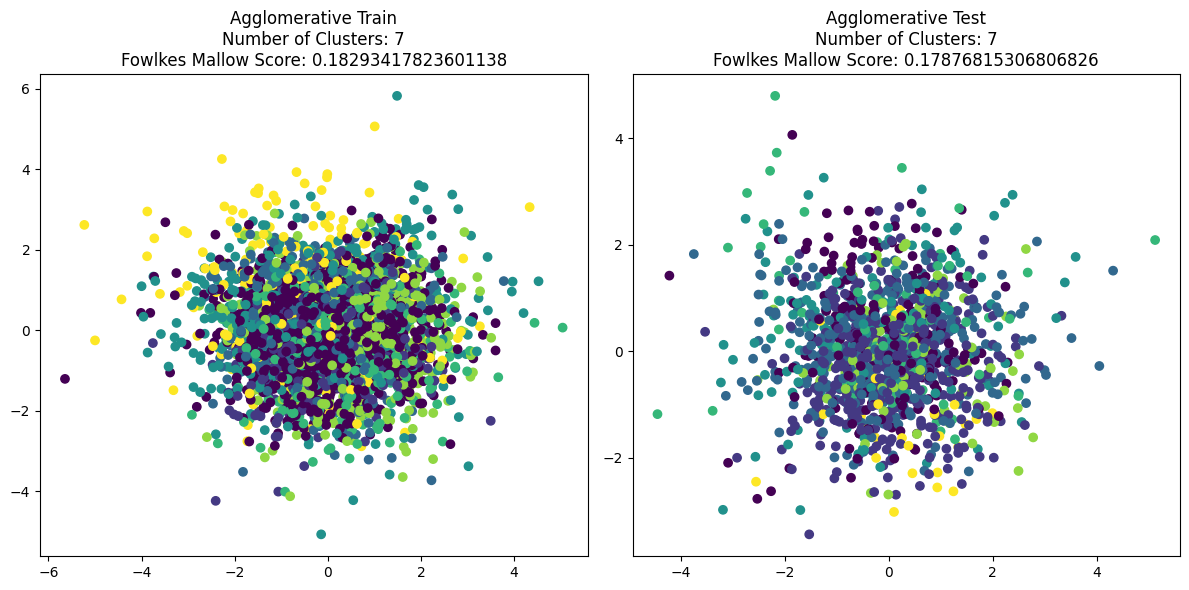

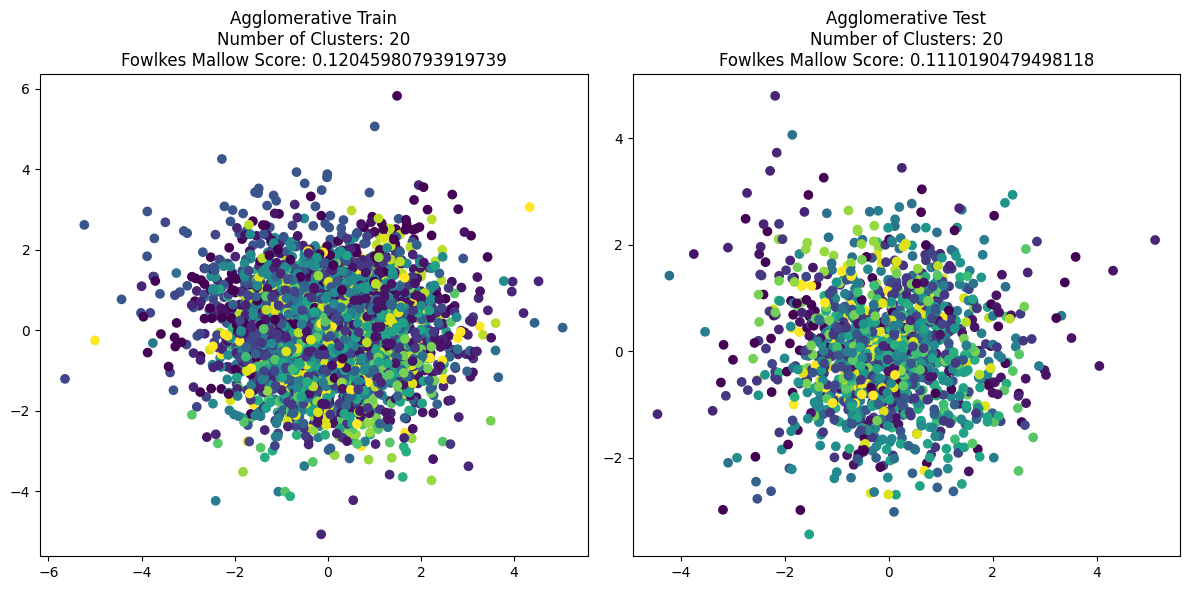

In [64]:
for n_clusters in clusters:
    agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
    agglomerative.fit(X_train_lda)
    # print('Number of clusters = ', n_clusters)
    evaluate_clustering(agglomerative, number_of_clusters=n_clusters, model_name="Agglomerative")
    plt.show()

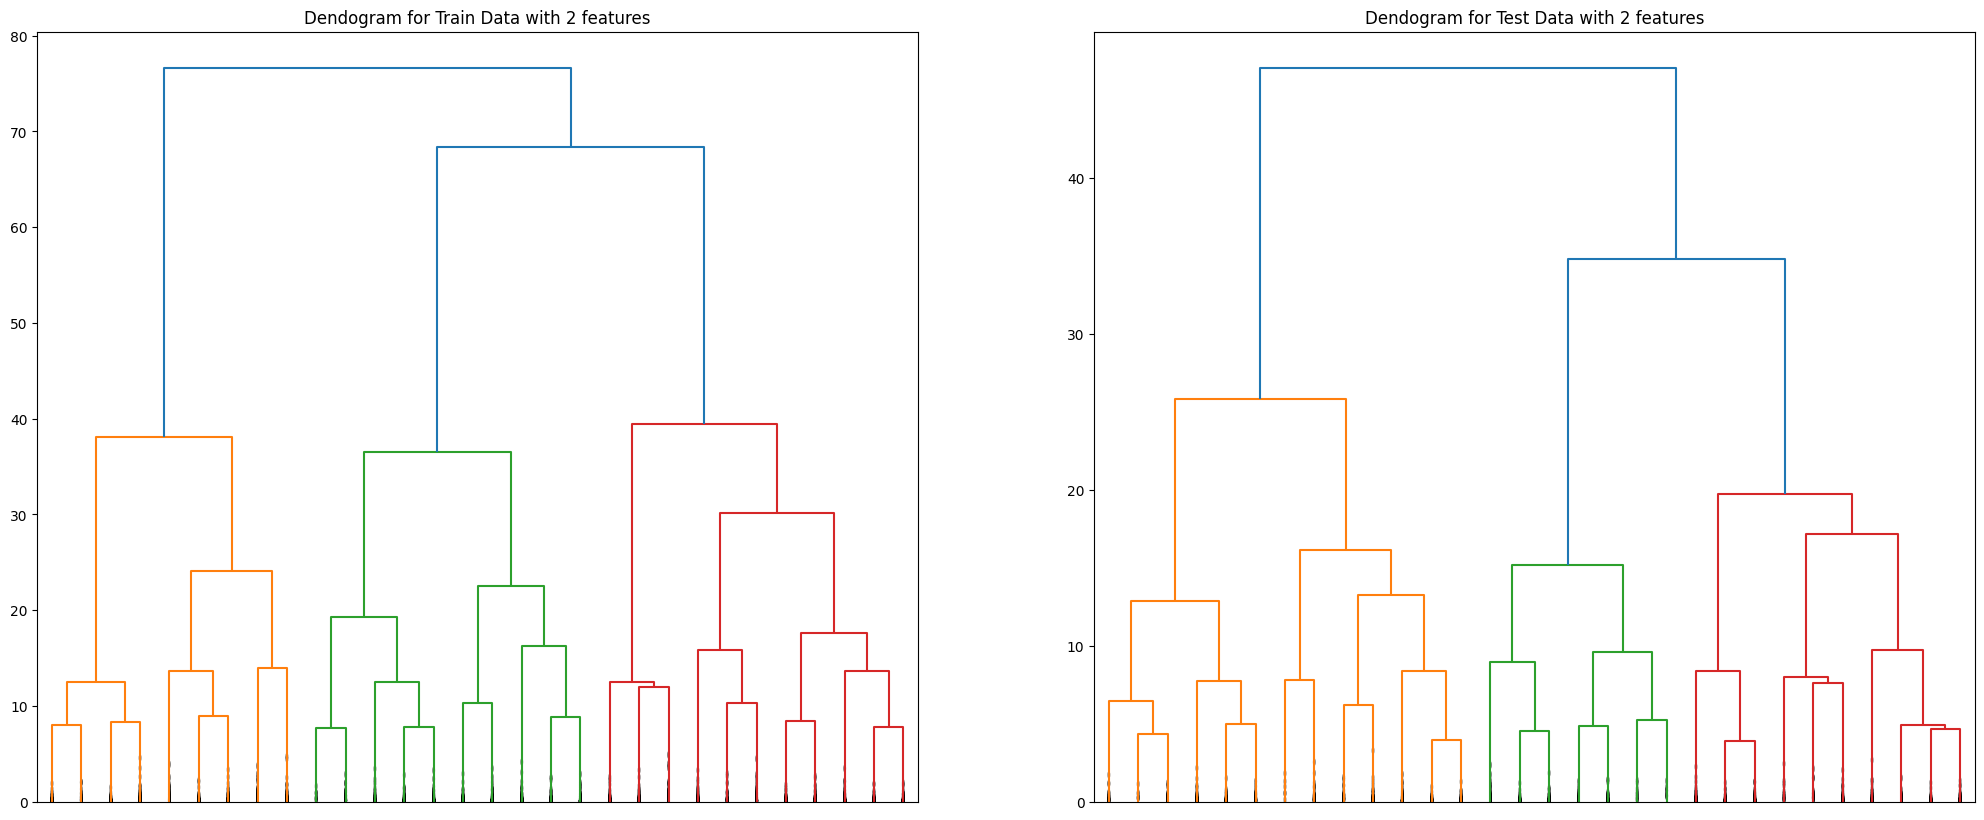

In [65]:
plot_dendrogram( X_train_lda,X_test_lda,num_of_features=2)

# Clustring Using Data with 3 Features

In [66]:
dr = DimensionReduction(X_train, y_train, X_test, y_test)
X_train_lda, X_test_lda = dr.LDA(n_components=3)

## K-Means

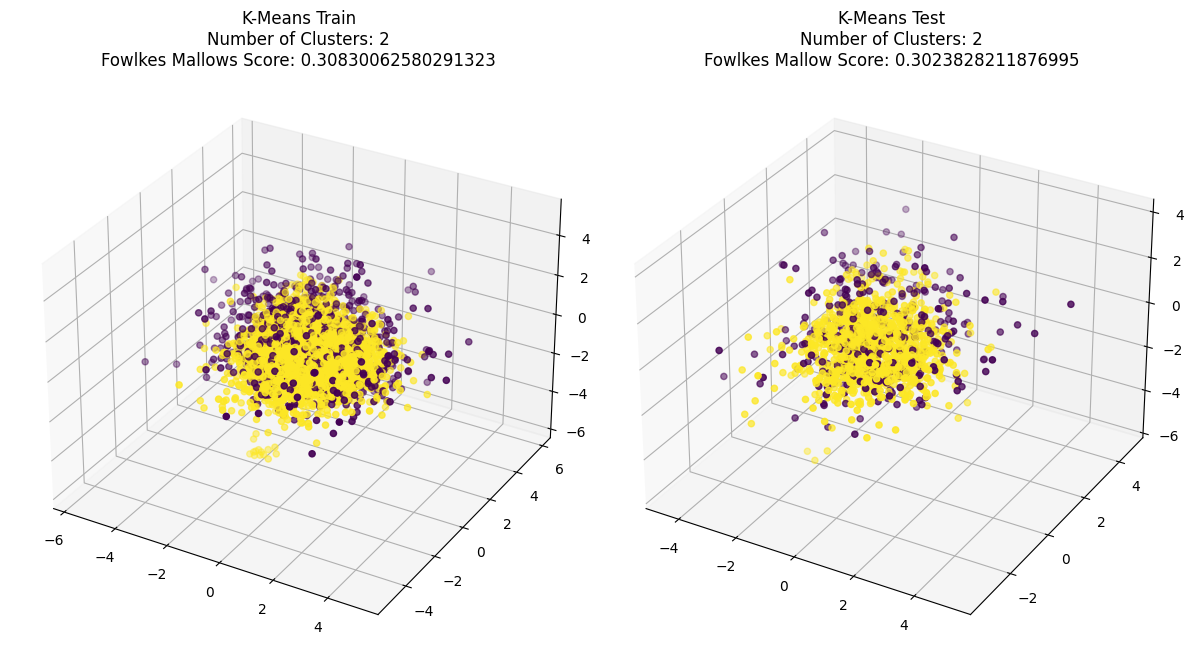

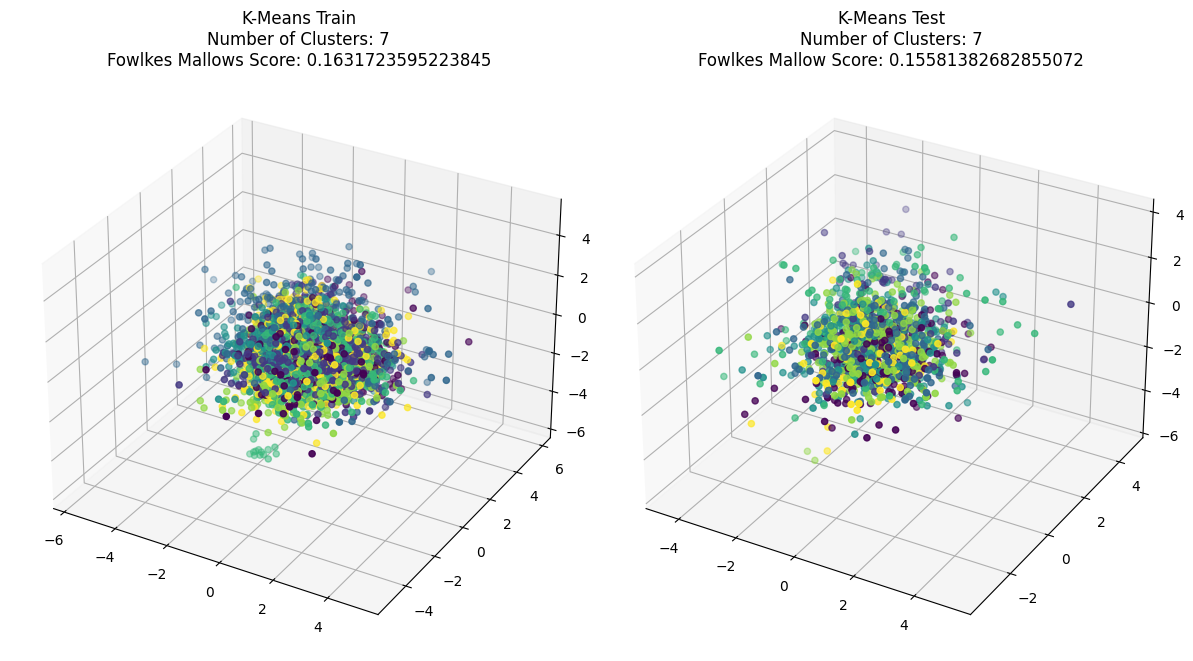

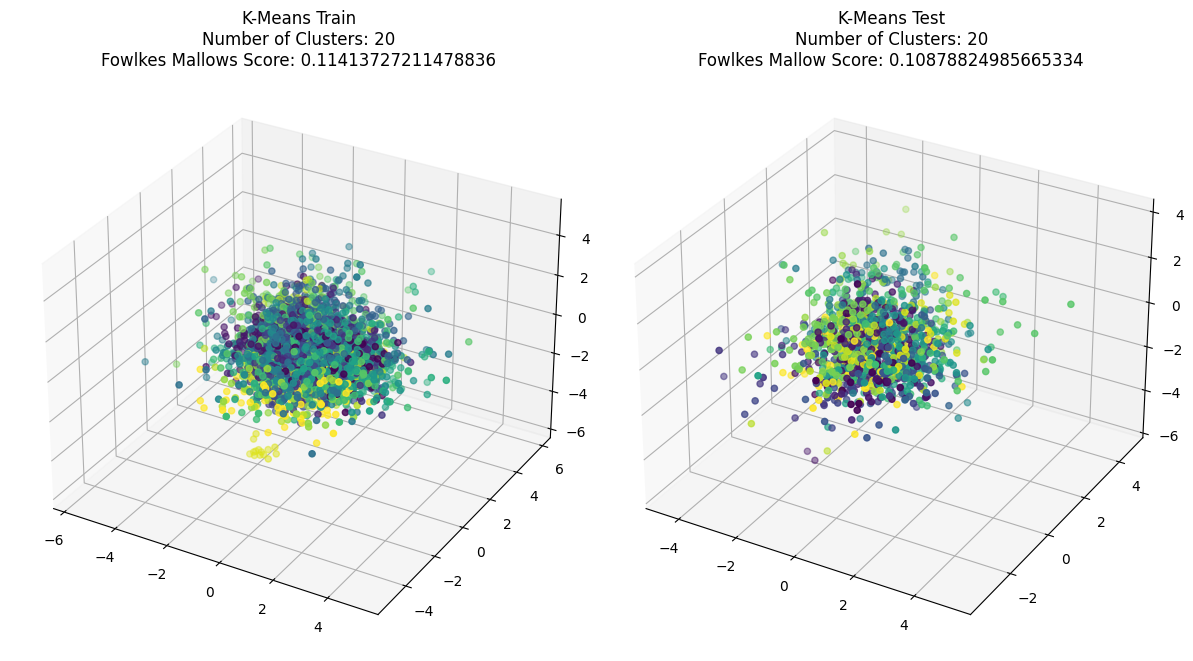

In [67]:
for n_clusters in clusters:
    kMeans = KMeans(n_clusters=n_clusters, init='k-means++', algorithm='elkan', max_iter=100)
    kMeans.fit(X_train_lda)
    # print('Number of clusters = ', n_clusters)
    evaluate_clustering(kMeans, number_of_clusters=n_clusters, model_name="K-Means", d=3)
    plt.show()

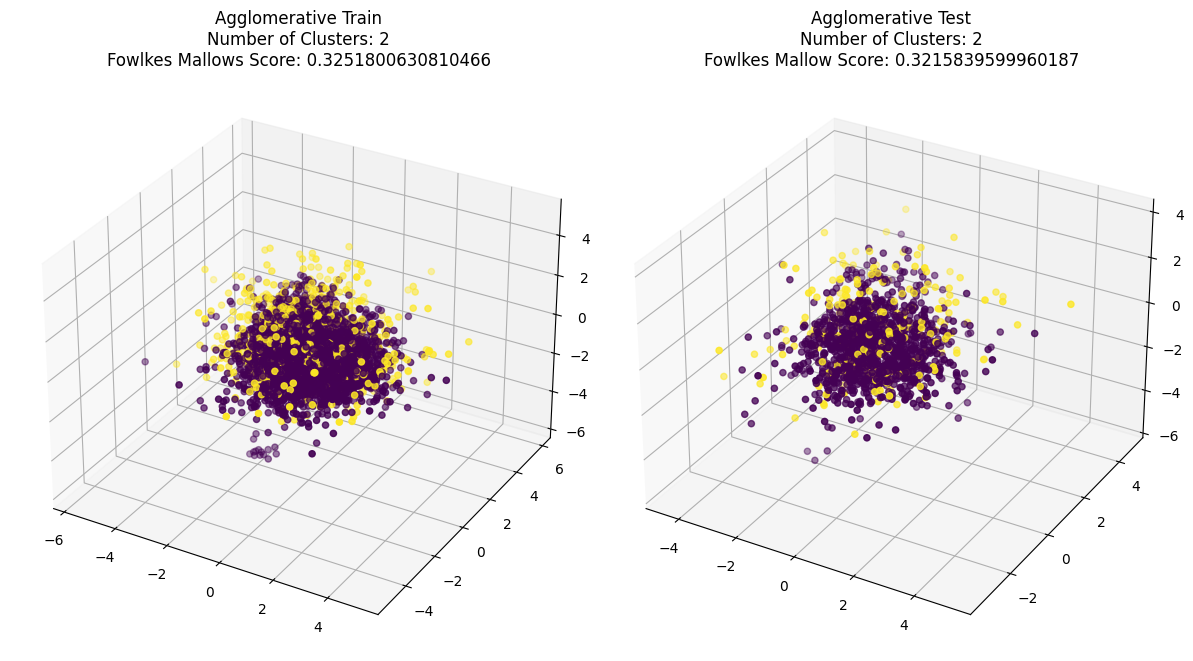

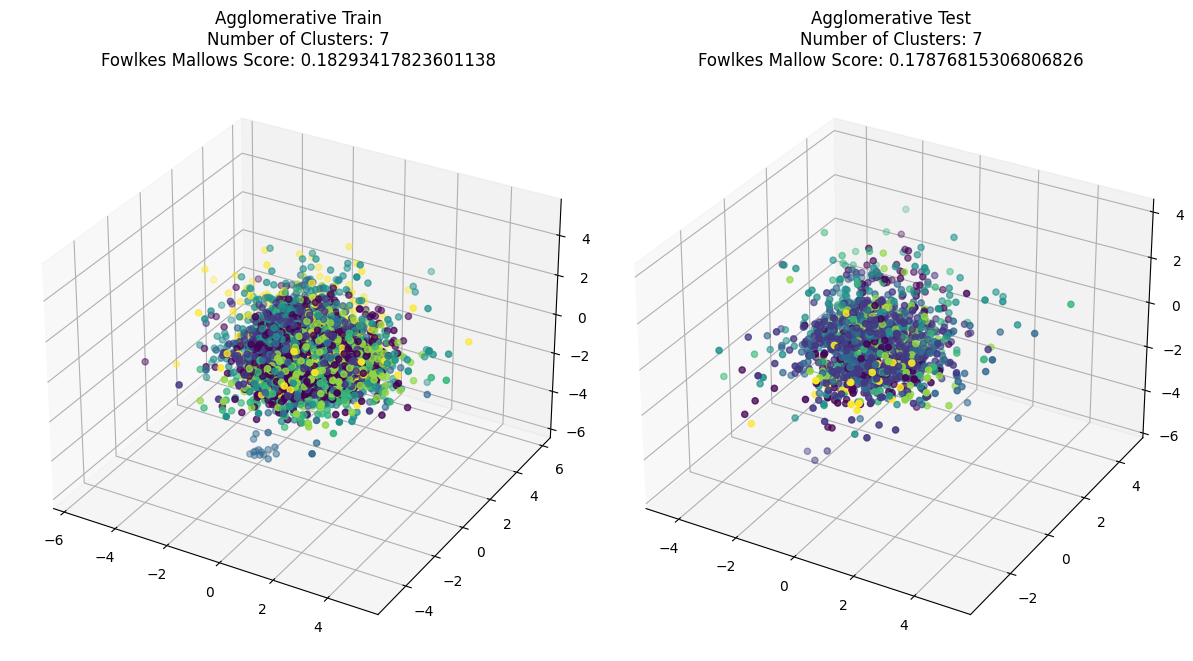

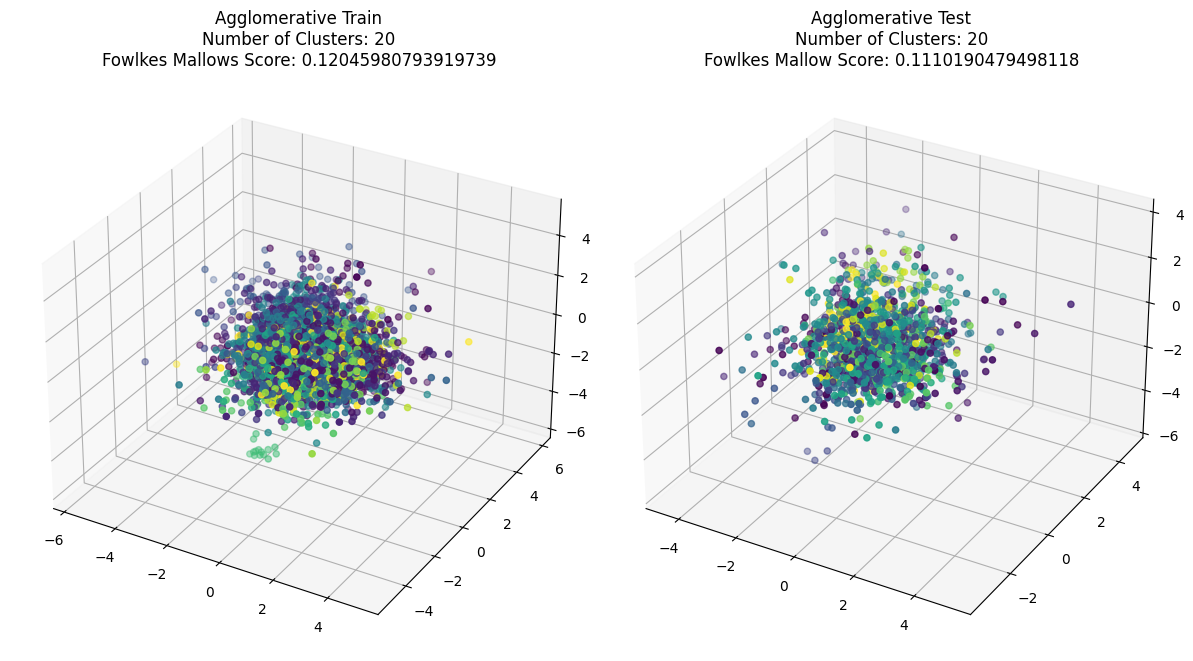

In [68]:
for n_clusters in clusters:
    agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
    agglomerative.fit(X_train_lda)
    # print('Number of clusters = ', n_clusters)
    evaluate_clustering(agglomerative, number_of_clusters=n_clusters, model_name="Agglomerative", d=3)
    plt.show()

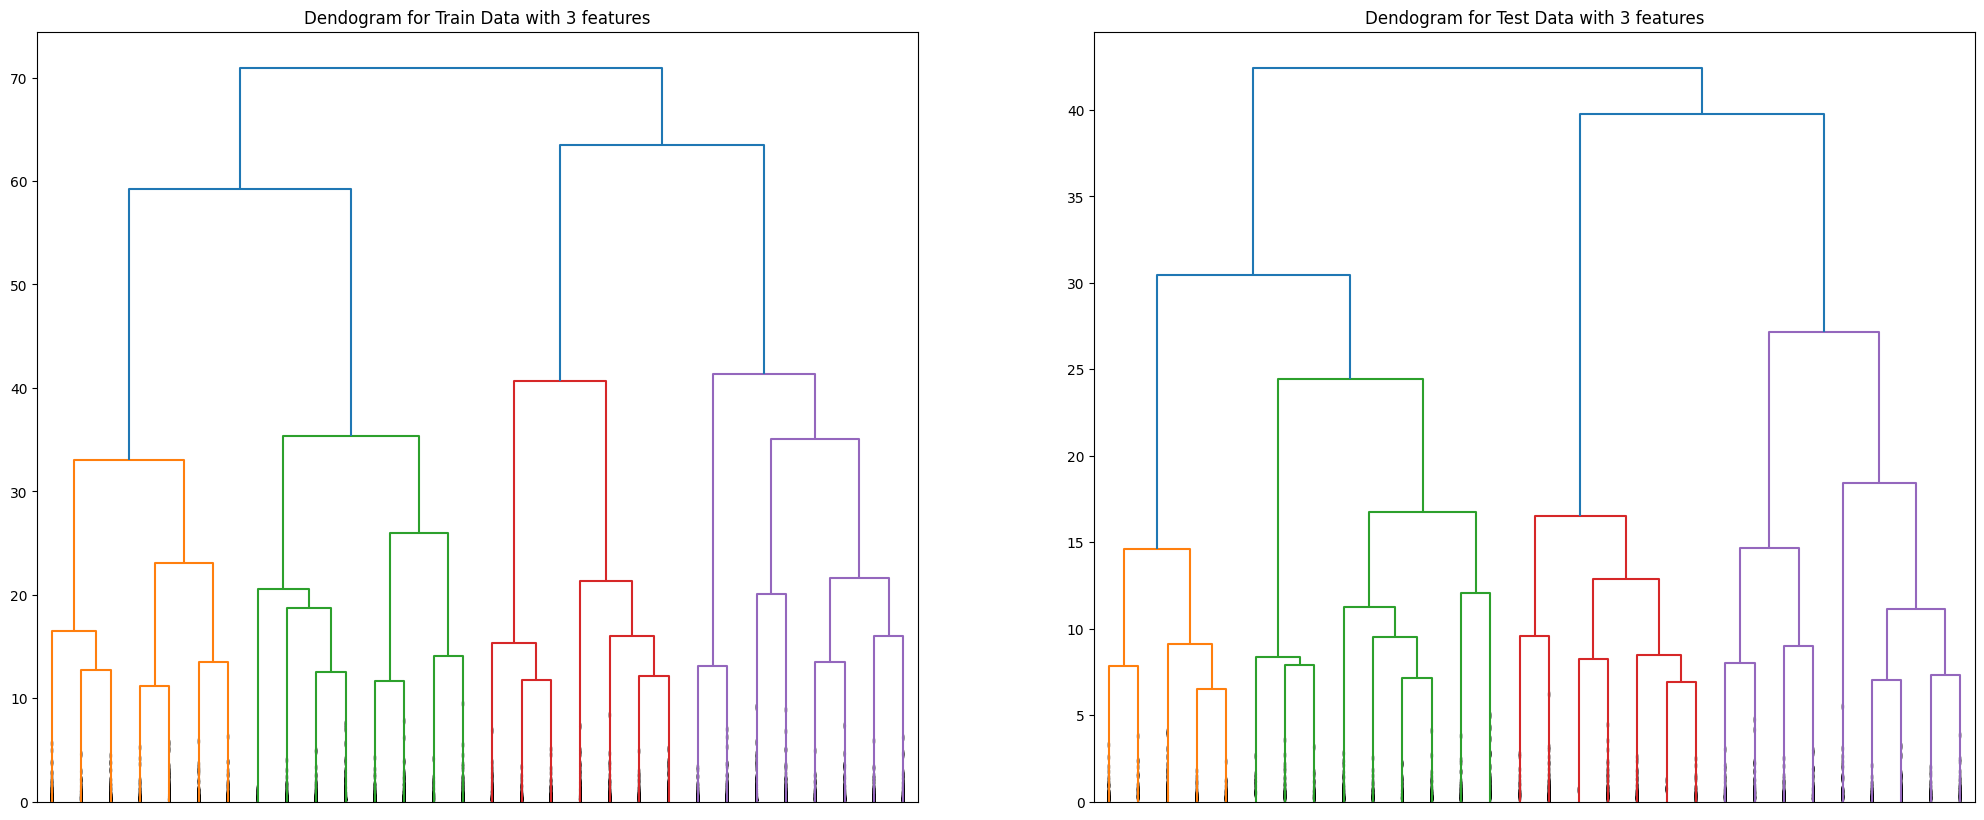

In [69]:
plot_dendrogram( X_train_lda,X_test_lda,num_of_features=3)